# Financial Analysis with the `stock_analysis` package
In this chapter, we will build the [`stock_analysis` package](https://github.com/stefmolin/stock-analysis) using everything we learned in the book so far, and use it for some basic technical analysis of financial assets. Here is a breakdown of the classes we will use and their purposes:

| Purpose | Class(es) | Module |
| --- | --- | --- |
| Collecting the data from various sources | `StockReader` | `stock_reader.py` |
| Visualizing the data | `Visualizer`, `StockVisualizer`, `AssetGroupVisualizer` | `stock_visualizer.py` |
| Calculating financial metrics | `StockAnalyzer`, `AssetGroupAnalyzer` | `stock_analyzer.py` |
| Modeling the data | `StockModeler` | `stock_modeler.py` |

## Data Extraction
The `StockReader` class in the `stock_analysis` package makes it easy to collect financial data, like stock market or bitcoin prices. We simply have to create an instance by specifying the date range. Then, we can grab the data we wish:

In [1]:
import stock_analysis

reader = stock_analysis.StockReader('2017-01-01', '2018-12-31')

# get bitcoin data
bitcoin = reader.get_bitcoin_data()

# get faang data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

# get S&P 500 data
sp = reader.get_index_data()

## EDA
We can group our assets together in dataframes in order to perform EDA:

In [2]:
from stock_analysis.utils import group_stocks, describe_group

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

faang_sp = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog,
        'S&P 500': sp
    }
)

bit_sp = group_stocks(
    {
        'Bitcoin': bitcoin,
        'S&P 500': sp
    }
)

all_assets = group_stocks(
    {
        'Bitcoin': bitcoin,
        'S&P 500': sp,
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

This makes it easy to describe them all at once:

In [3]:
describe_group(all_assets).loc['close',]

name,Amazon,Apple,Bitcoin,Facebook,Google,Netflix,S&P 500
count,502.000000,502.000000,730.000000,502.000000,502.000000,502.000000,502.000000
mean,1304.946594,42.450563,5789.166247,164.043566,1017.502986,242.332291,2597.645281
std,372.471605,6.565316,3794.382038,20.142954,120.077762,85.760210,181.994087
min,753.669983,29.004999,777.760000,116.860001,786.140015,127.489998,2257.830078
25%,967.992493,38.050624,2589.457500,148.500000,929.700012,162.569996,2434.777527
50%,1194.714966,42.185001,6252.710000,167.544998,1028.989990,201.875000,2629.420044
75%,1623.527496,46.500626,7672.175000,178.762505,1103.907471,321.264992,2742.534912
max,2039.510010,58.017502,19497.400000,217.500000,1268.329956,418.970001,2930.750000


It's a dataframe so we can transpose it to view it easier. Here we see that we have more entries for bitcoin than the S&P 500 because bitcoin prices change daily.

In [4]:
describe_group(bit_sp).loc['close',].T

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
Bitcoin,730.0,5789.166247,3794.382038,777.760000,2589.457500,6252.710000,7672.175000,19497.40
S&P 500,502.0,2597.645281,181.994087,2257.830078,2434.777527,2629.420044,2742.534912,2930.75


We can compare the FAANG stocks to each other:

In [5]:
describe_group(faang).loc[['close', 'volume'],]

name                Amazon         Apple      Facebook        Google  \
close  count  5.020000e+02  5.020000e+02  5.020000e+02  5.020000e+02   
       mean   1.304947e+03  4.245056e+01  1.640436e+02  1.017503e+03   
       std    3.724716e+02  6.565316e+00  2.014295e+01  1.200778e+02   
       min    7.536700e+02  2.900500e+01  1.168600e+02  7.861400e+02   
       25%    9.679925e+02  3.805062e+01  1.485000e+02  9.297000e+02   
       50%    1.194715e+03  4.218500e+01  1.675450e+02  1.028990e+03   
       75%    1.623527e+03  4.650063e+01  1.787625e+02  1.103907e+03   
       max    2.039510e+03  5.801750e+01  2.175000e+02  1.268330e+03   
volume count  5.020000e+02  5.020000e+02  5.020000e+02  5.020000e+02   
       mean   4.582875e+06  1.223093e+08  2.222427e+07  1.609240e+06   
       std    2.418694e+06  5.399572e+07  1.553659e+07  6.908951e+05   
       min    1.585100e+06  5.005560e+07  8.190300e+06  5.370000e+05   
       25%    2.907825e+06  8.519860e+07  1.385520e+07  1.184350e+06   
       50%    3.773900e+06  1.068838e+08  1.805165e+07  1.401700e+06   
       75%    5.599425e+06  1.425951e+08  2.434852e+07  1.845650e+06   
       max    1.656500e+07  4.479400e+08  1.698037e+08  5.167700e+06   

name               Netflix  
close  count  5.020000e+02  
       mean   2.423323e+02  
       std    8.576021e+01  
       min    1.274900e+02  
       25%    1.625700e+02  
       50%    2.018750e+02  
       75%    3.212650e+02  
       max    4.189700e+02  
volume count  5.020000e+02  
       mean   9.029815e+06  
       std    5.520675e+06  
       min    2.160500e+06  
       25%    5.299525e+06  
       50%    7.451150e+06  
       75%    1.121950e+07  
       max    5.841040e+07

### Visualizations
The `StockVisualizer` class makes it easy to create a variety of visualizations for financial analysis. We simply pass in the dataframe of the asset we want to visualize:

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

netflix_viz = stock_analysis.StockVisualizer(nflx)

We can use the `pairplot()` method to see the `seaborn.pairplot()` of the OHLC data:

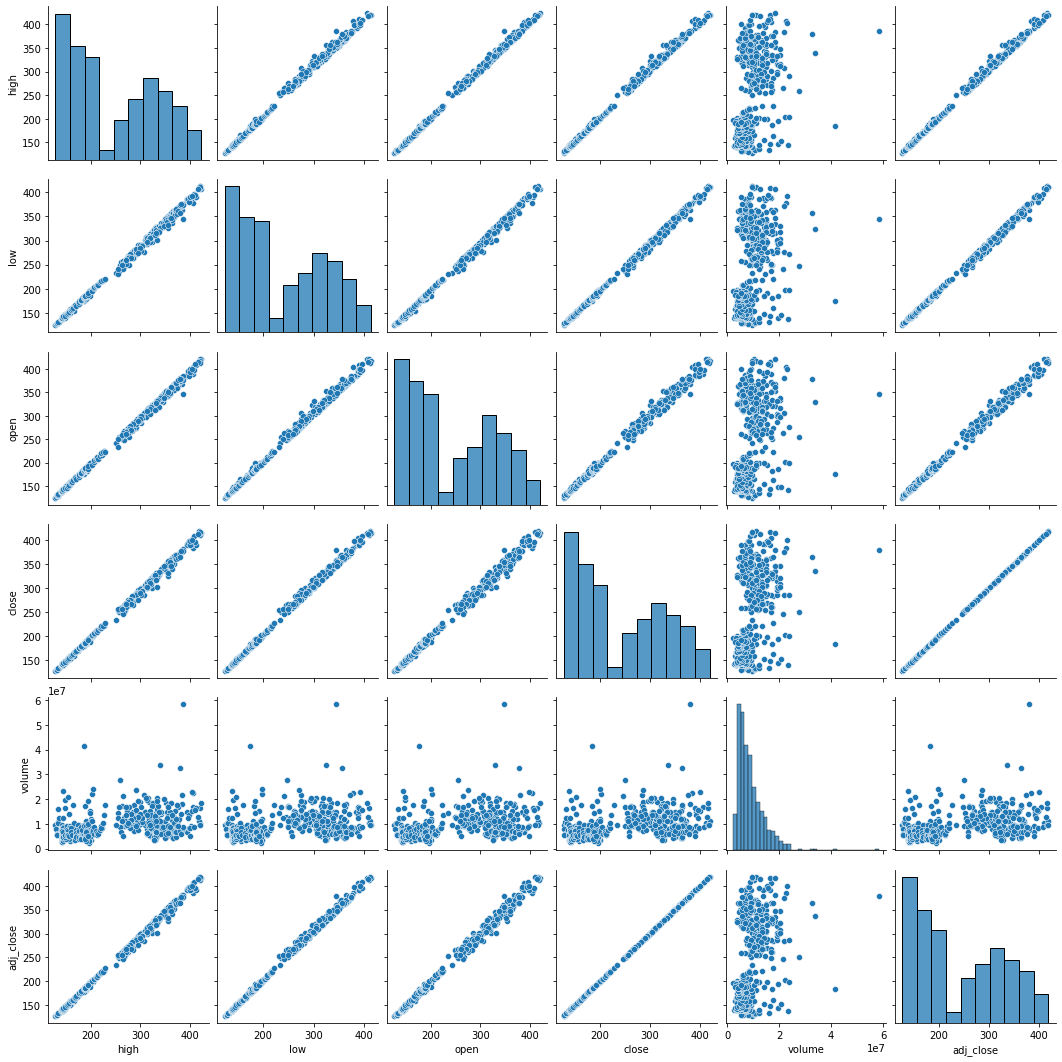

In [7]:
netflix_viz.pairplot()

*Note: to look at quarterly performance in the pairplot as we did in chapter 6, add a `quarter` column to the Netflix dataframe before creating the `StockVisualizer` object and pass `hue='quarter'` to the `pairplot()` method.*

We can plot the evolution of a column over time to see how the price changed and add reference lines as we please:

Text(0, 0.5, 'price ($)')

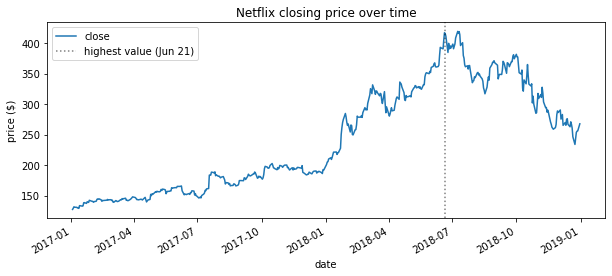

In [8]:
ax = netflix_viz.evolution_over_time(
    'close', 
    figsize=(10, 4), 
    legend=False, 
    title='Netflix closing price over time'
)
netflix_viz.add_reference_line(
    ax, 
    x=nflx.high.idxmax(), 
    color='k', 
    linestyle=':', 
    label=f'highest value ({nflx.high.idxmax():%b %d})',
    alpha=0.5
)
ax.set_ylabel('price ($)')

July 2018 was a rough month for Netflix with after-hours trading:

array([<AxesSubplot:title={'center':"After-hours trading\n(Open Price - Prior Day's Close)"}, xlabel='date', ylabel='price'>,
       <AxesSubplot:title={'center':'After-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
      dtype=object)

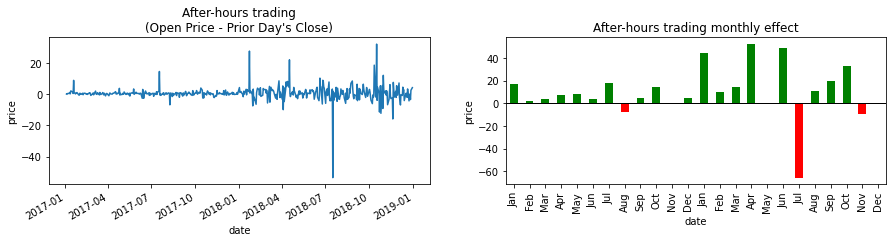

In [9]:
netflix_viz.after_hours_trades()

Facebook had many more rough months:

array([<AxesSubplot:title={'center':"After-hours trading\n(Open Price - Prior Day's Close)"}, xlabel='date', ylabel='price'>,
       <AxesSubplot:title={'center':'After-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
      dtype=object)

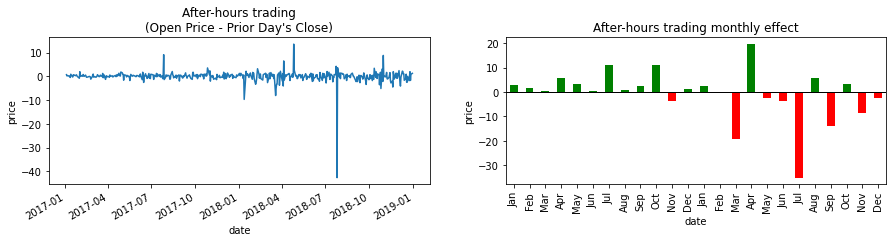

In [10]:
# compare to FB
stock_analysis.StockVisualizer(fb).after_hours_trades()

We can look at the volume traded and stock price over time to see that while the Netflix stock price has trended up so has volume traded.

<AxesSubplot:xlabel='date', ylabel='price'>

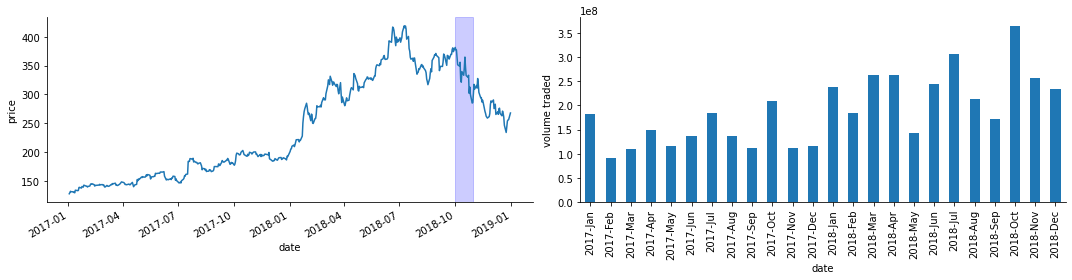

In [11]:
ax = netflix_viz.trade_volume()
netflix_viz.shade_region(
    ax[0], x=('2018-10-01', '2018-10-31'), color='blue', 
    alpha=0.2, label='highest trade volume'
)

We can use the moving average to smooth out the trend for the stock. Notice the fall Netflix took in July 2018 pushed the moving averages below the stock price while they had been above the stock price in the past.

Text(0, 0.5, 'price ($)')

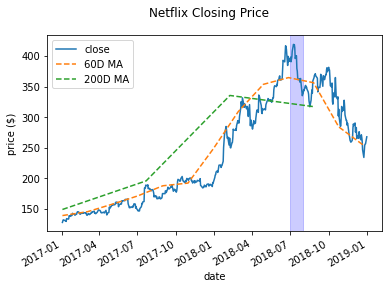

In [12]:
ax = netflix_viz.moving_average('close', ['60D', '200D'])
netflix_viz.shade_region(
    ax, x=('2018-07-01', '2018-07-31'), color='blue', alpha=0.2
)
plt.suptitle('Netflix Closing Price')
plt.ylabel('price ($)')

The moving average may be used to determine support and resistance levels. Support exerts upward pressure on the stock price (lower prices get people to buy) and resistance exerts downward force on the stock price (high prices cause people to sell):

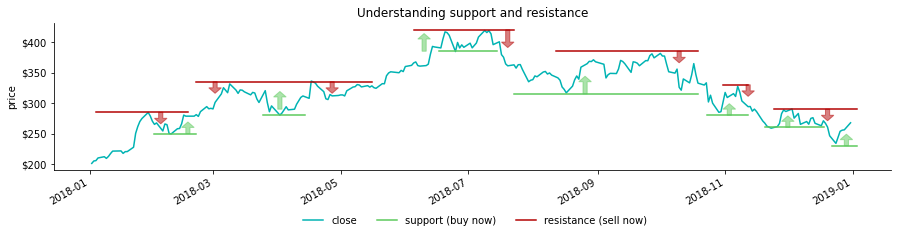

In [13]:
from visual_aids import finance_viz
_ = finance_viz.support_and_resistance()

Sometimes exponential smoothing makes more sense because we can place higher importance on more recent values. Notice how the exponentially smoothed curves more closely track the stock price compared to the moving average with equally weighted observations (especially in the shaded region where the drop occurred):

Text(0, 0.5, 'price ($)')

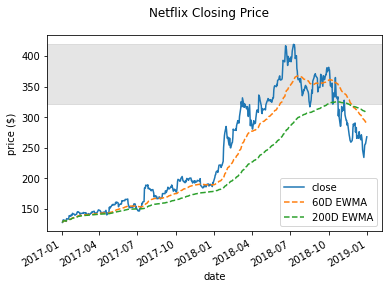

In [14]:
ax = netflix_viz.exp_smoothing('close', [60, 200])
q_3, q_4 = nflx.close.quantile([0.75, 1])
netflix_viz.shade_region(
    ax, y=(q_3, q_4), color='grey', alpha=0.2
)
plt.suptitle('Netflix Closing Price')
plt.ylabel('price ($)')

If you follow the installation instructions [here](https://github.com/matplotlib/jupyter-matplotlib), you can run the following interactive plot to see what different windows do to the moving average and exponentially smoothed moving average. This requires you to install `ipyml` and `node.js` and run a few commands from the command line as indicated in the aforementioned link. Note you will need to restart the kernel.

First, we run this magic:

In [15]:
%matplotlib widget

*More information on the `interact()` function can be found [here](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html).*

In [ ]:
from ipywidgets import interact

def moving_averages(viz):
    def plot_viz(period=20, exponentially_smoothed=False):
        if exponentially_smoothed:
            ax = netflix_viz.exp_smoothing('close', period)
        else:
            ax = netflix_viz.moving_average('close', str(period) + 'D')
        netflix_viz.shade_region(
            ax, x=('2018-07-01', '2018-07-31'), color='blue', alpha=0.2
        )
        
        plt.suptitle('Netflix Closing Price')
        plt.ylabel('price ($)')
    
    return plot_viz
interact(moving_averages(netflix_viz), period=(5, 200, 5), exponentially_smoothed=False);

Switch back to `inline` plots:

In [17]:
%matplotlib inline

Netflix hit its max and has been trending downward:

Text(0, 0.5, 'price ($)')

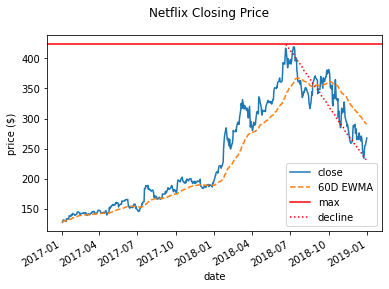

In [18]:
import numpy as np
ax = netflix_viz.exp_smoothing('close', 60)
netflix_viz.add_reference_line(
    ax, y=nflx.high.max(), color='red', linestyle='-', label='max'
)
nflx_decline = nflx[nflx.high.idxmax():]
netflix_viz.add_reference_line(
    ax, 
    x=nflx_decline.index, 
    y=np.linspace(
        nflx_decline.high.max(), 
        nflx_decline.low.min(), 
        num=nflx_decline.shape[0]
    ), 
    color='r', 
    linestyle=':', 
    label='decline'
)
plt.suptitle('Netflix Closing Price')
plt.ylabel('price ($)')

We can use a joint plot to see how Netflix compared to the S&P 500:

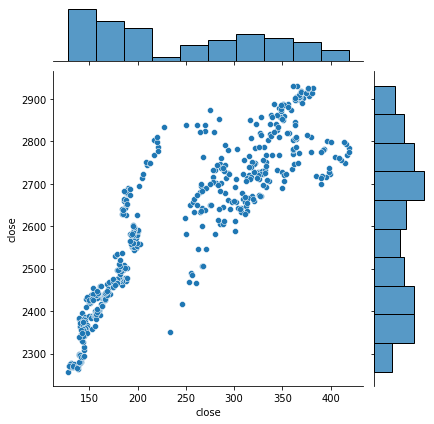

In [19]:
netflix_viz.jointplot(sp, 'close')

Netflix and Facebook both struggled in July 2018, but their correlation is weak:

<AxesSubplot:>

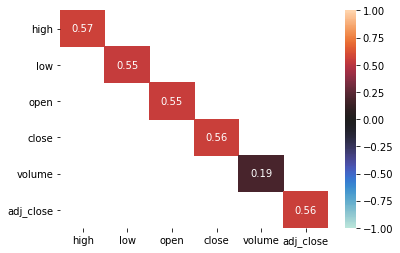

In [20]:
netflix_viz.correlation_heatmap(fb)

We can see that Facebook and Netflix had similar stock prices in 2017, but Netflix really pulled ahead in 2018, despite taking a tumble (because Facebook did as well):

Text(0, 0.5, 'price')

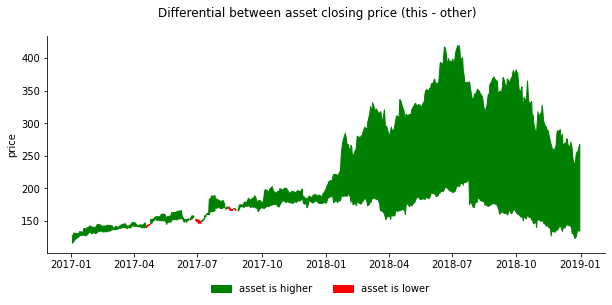

In [21]:
netflix_viz.fill_between_other(fb)

If we want to visualize groups of assets, we use the `AssetGroupVisualizer`. Let's look at the correlations between the assets:

<AxesSubplot:xlabel='name', ylabel='name'>

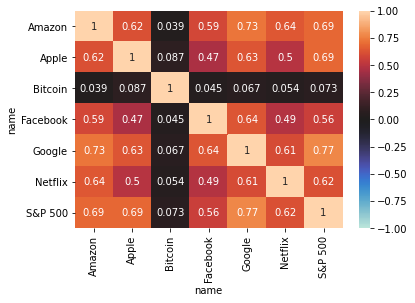

In [22]:
all_assets_viz = stock_analysis.AssetGroupVisualizer(all_assets)
all_assets_viz.heatmap(True)

We can view the effect that after-hours trading had on each of the FAANG stocks:

array([[<AxesSubplot:title={'center':"Amazon Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Amazon after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Apple Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Apple after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Facebook Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Facebook after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Google Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Google after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Netflix Open Price - Prior Day's Close"}, xlabel='da

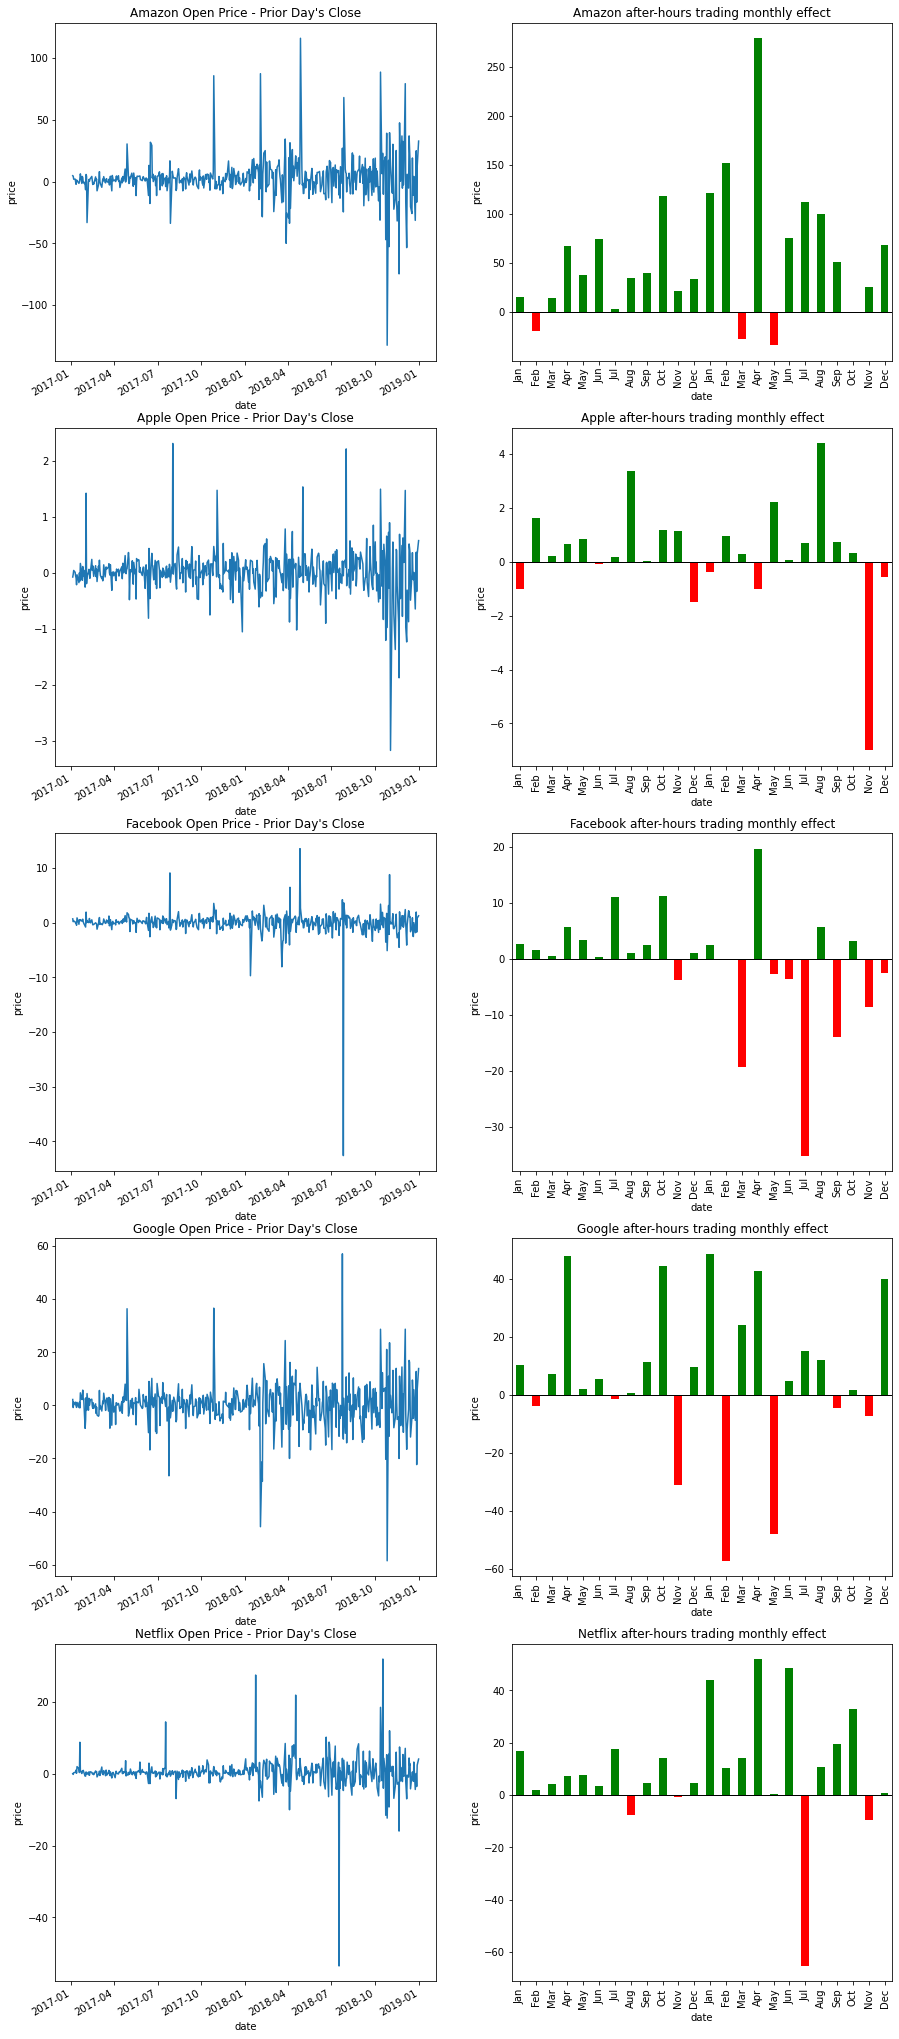

In [23]:
faang_viz = stock_analysis.AssetGroupVisualizer(faang)
faang_viz.after_hours_trades()

We can look at what the exponentially smoothed moving averages look like for all FAANG stocks as well:

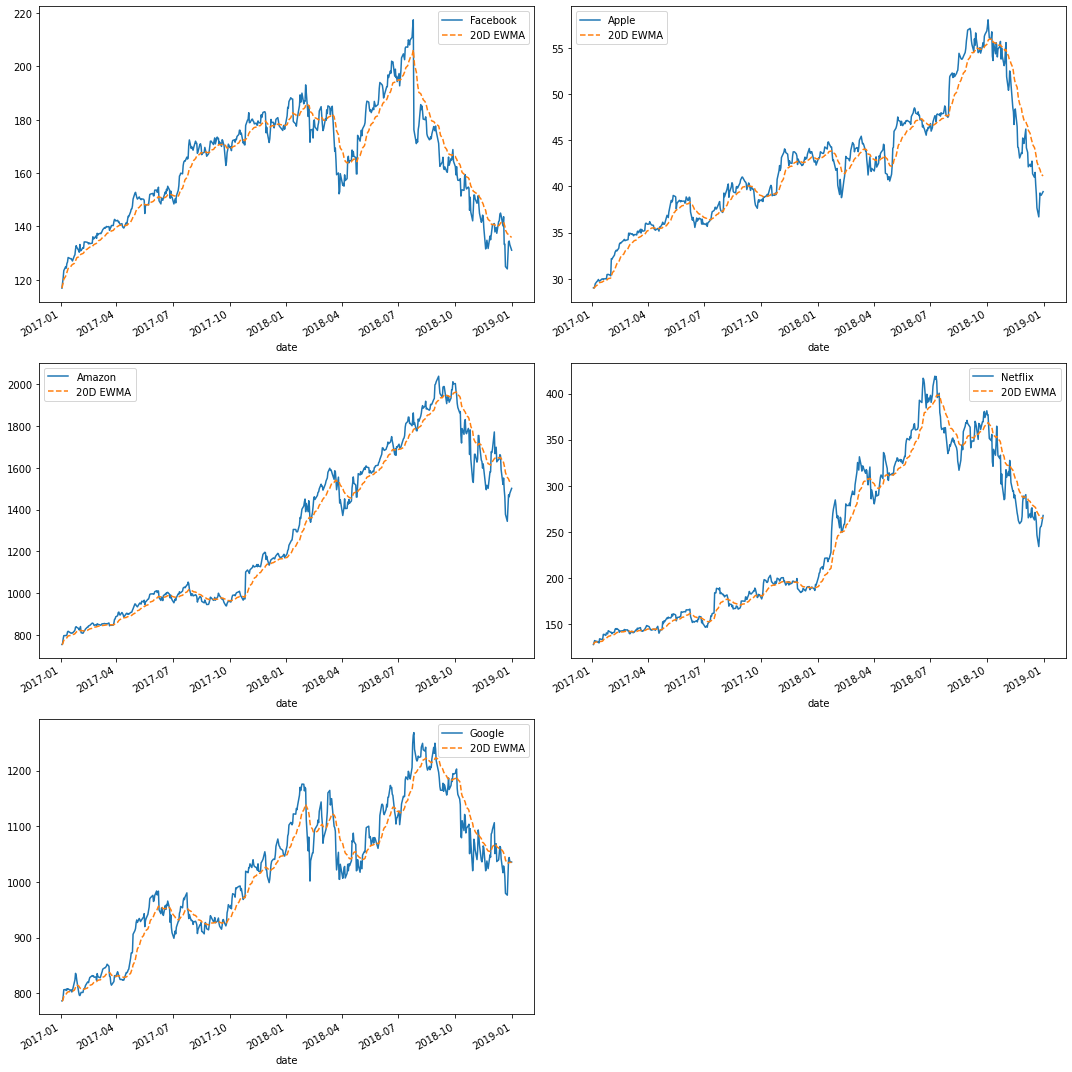

In [24]:
faang_viz.exp_smoothing('close', 20)
plt.tight_layout()

With short windows, both these smoothing methods perform similarly:

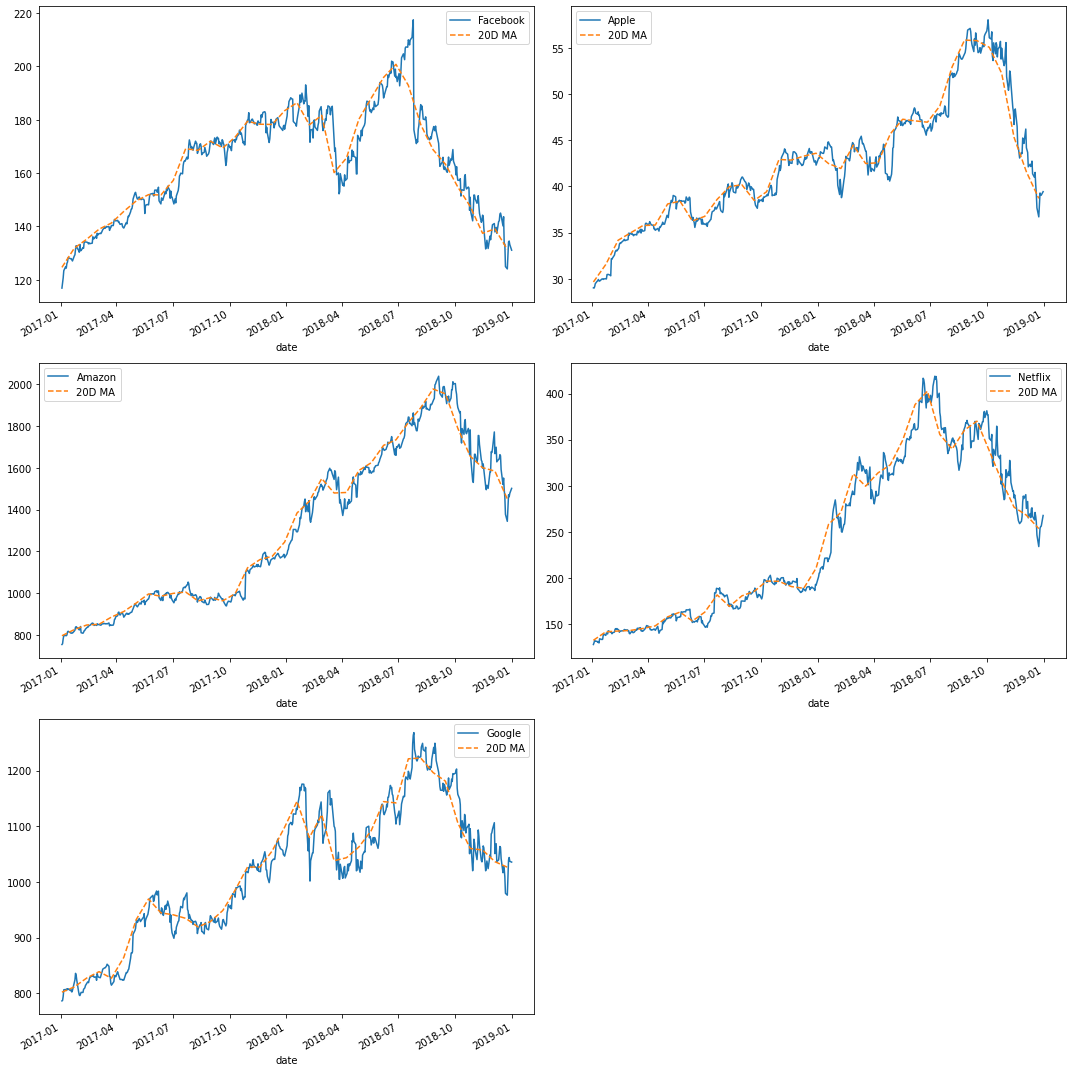

In [25]:
faang_viz.moving_average('close', '20D')
plt.tight_layout()

The distributions of closing price across the FAANG stocks are quite different:

array([<AxesSubplot:title={'center':'Amazon - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:title={'center':'Apple - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:title={'center':'Facebook - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:title={'center':'Google - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:title={'center':'Netflix - close'}, xlabel='close', ylabel='Count'>,
       <AxesSubplot:>], dtype=object)

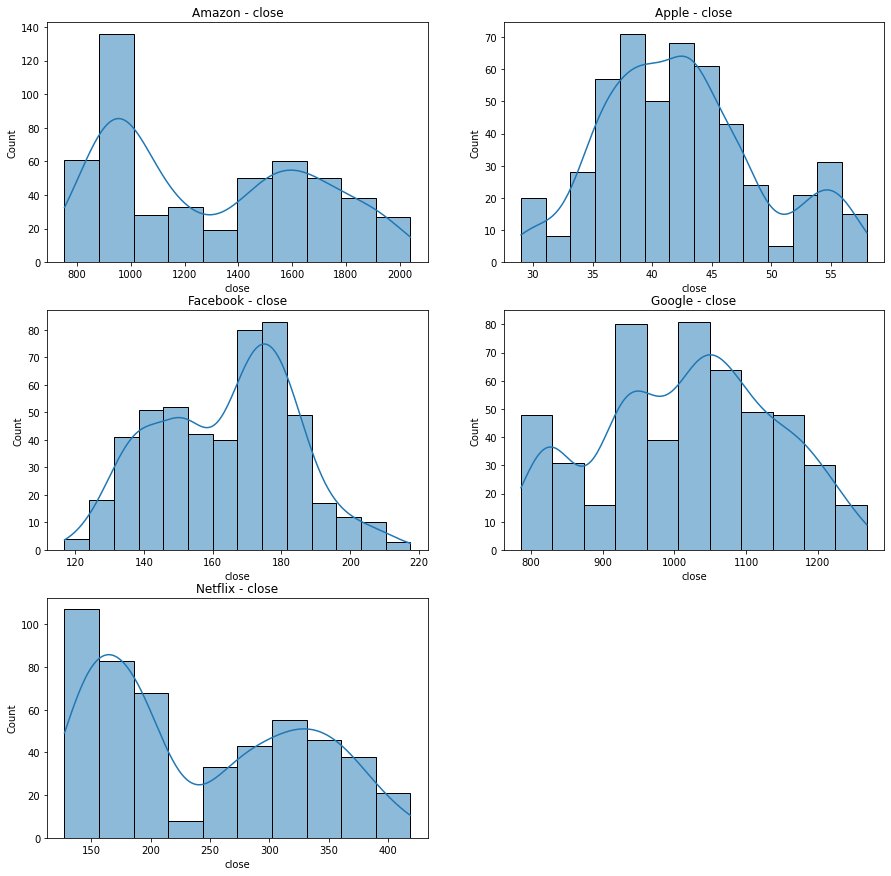

In [26]:
faang_viz.histogram('close')

Viewing box plots we can easily see that Google and Amazon are on a much larger scale:

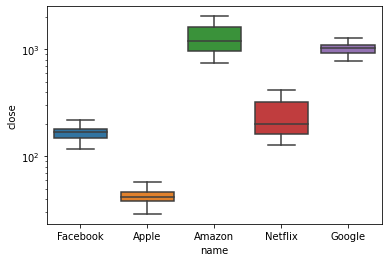

In [27]:
faang_viz.boxplot('close')
plt.yscale('log')

Plotting all the FAANG stocks' closing prices over time shows that early 2018 had a lot of growth for the lot of them:

<AxesSubplot:xlabel='date', ylabel='close'>

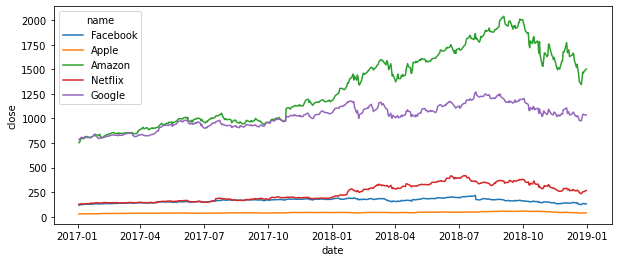

In [28]:
faang_viz.evolution_over_time('close')

Correlations between the stocks are weak, with the strongest being between Google and Amazon:

<AxesSubplot:xlabel='name', ylabel='name'>

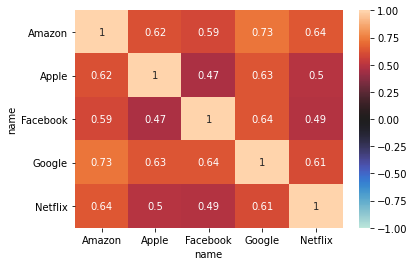

In [29]:
faang_viz.heatmap(True)

We can view this information as scatter plots as well:

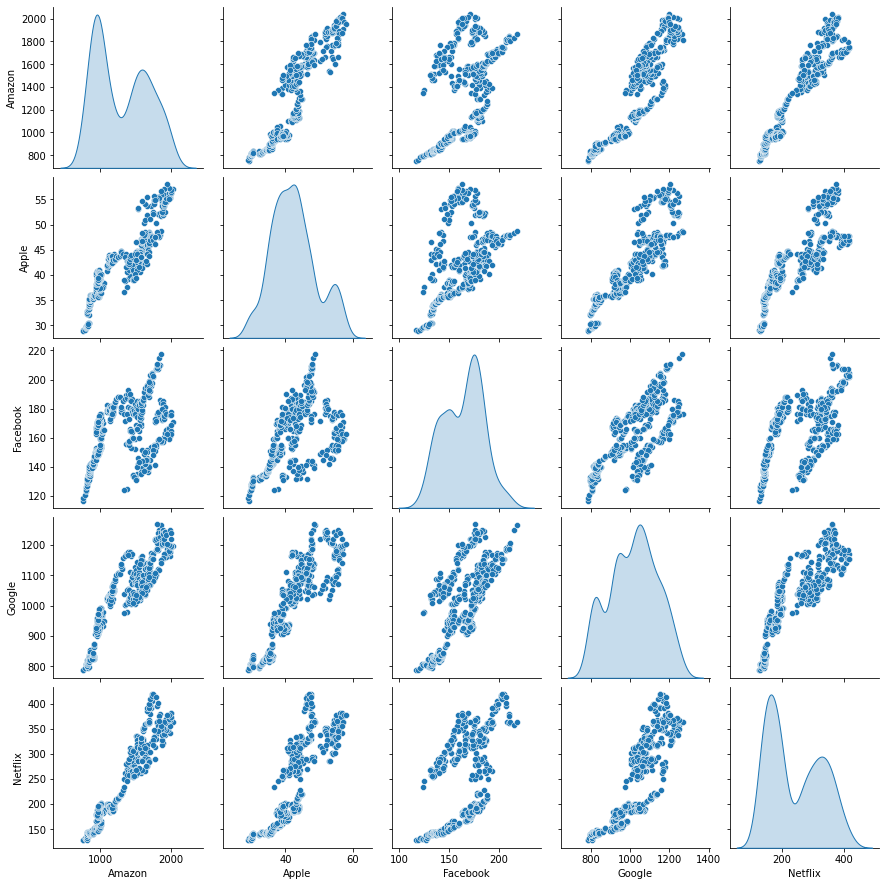

In [30]:
faang_viz.pairplot()

Bitcoin is on a much larger scale so we have to use subplots to compare it to the stock market. Notice that bitcoin took a huge tumble (check out the scale on the y-axis):

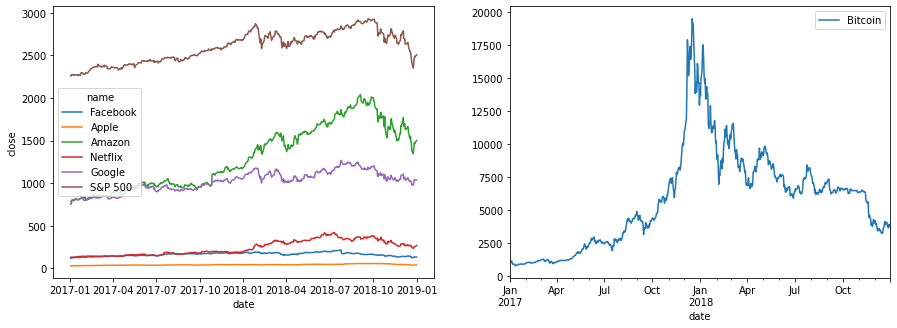

In [31]:
faang_sp_viz = stock_analysis.AssetGroupVisualizer(faang_sp)
bitcoin_viz = stock_analysis.StockVisualizer(bitcoin)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
faang_sp_viz.evolution_over_time('close', ax=axes[0])
bitcoin_viz.evolution_over_time('close', ax=axes[1], label='Bitcoin')

## Technical Analysis
Technical analysis involves looking at metrics to understand the peformance of an asset.
### Single Asset
We can use the `StockAnalyzer` to calculate metrics for us:

In [32]:
nflx_analyzer = stock_analysis.StockAnalyzer(nflx)

One such metric is annualized volatility:

In [33]:
nflx_analyzer.annualized_volatility()

0.46338087427831837

### Asset Groups
When working with groups, we use the `AssetGroupAnalyzer`:

In [34]:
all_assets_analyzer = stock_analysis.AssetGroupAnalyzer(
    all_assets
)

#### Coefficient of Variation
We can check how large the standard deviation is in terms of the mean of the stock price as another way to look at volatility. This shows that bitcoin is the most volatile:

In [35]:
all_assets_analyzer.analyze('cv')

{'Amazon': 0.2854305357937735,
 'Apple': 0.15465793302855302,
 'Bitcoin': 0.6554280661890078,
 'Facebook': 0.12279027356045312,
 'Google': 0.11801219659698321,
 'Netflix': 0.353895097112332,
 'S&P 500': 0.07006117737058823}

#### Annualized Volatility
Facebook looks more volatile using this metric than the previous, but it's just middle of the pack.

In [36]:
all_assets_analyzer.analyze('annualized_volatility')

{'Amazon': 0.3606494363818415,
 'Apple': 0.28709412666171025,
 'Bitcoin': 0.5395395749357711,
 'Facebook': 0.3798418843037499,
 'Google': 0.28079683703652936,
 'Netflix': 0.46338087427831837,
 'S&P 500': 0.17024852961093584}

#### Bear Market
We can check if the assets are in a bear market, meaning their value dropped 20% in the last 2 months:

In [37]:
all_assets_analyzer.analyze('is_bear_market')

{'Amazon': False,
 'Apple': True,
 'Bitcoin': True,
 'Facebook': False,
 'Google': False,
 'Netflix': False,
 'S&P 500': False}

#### Beta
Beta tells us how an asset's performance correlates to a market index. A beta of 1 with the S&P 500 means the asset moves with the S&P 500. Notice bitcoin is below one because it is a different type of asset.

In [38]:
all_assets_analyzer.analyze('beta', index=sp)

{'Amazon': 1.5811321378469285,
 'Apple': 1.2751991800296936,
 'Bitcoin': 0.5036241127304713,
 'Facebook': 1.2773890204543896,
 'Google': 1.3547553002014754,
 'Netflix': 1.8329279590822747,
 'S&P 500': 1.0}

#### Alpha
Alpha allows us to compare the returns of an asset to an index. We can compare to the S&P 500 using a risk-free rate of return of 2.69% (government treasury bond rate as of 12/31/18). You can look up rates [here](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yield). This shows that Facebook has worse returns and bitcoin much higher than the S&P 500 (due to scale): 

In [39]:
all_assets_analyzer.analyze('alpha', index=sp, r_f=2.69)

{'Amazon': 0.8341215037128584,
 'Apple': 0.22483040375692676,
 'Bitcoin': 2.6800626708247854,
 'Facebook': -0.011654097942395053,
 'Google': 0.17745988278082558,
 'Netflix': 0.9197077837724088,
 'S&P 500': 0.0}

#### Cumulative Returns
Cumulative returns show us what we would have made for a dollar investment at time period 0. This can be multiplied by the actual investment to get the return:

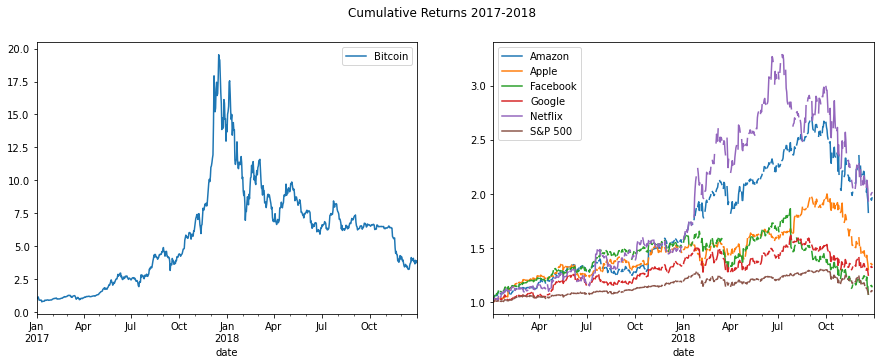

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cumulative_returns = all_assets_analyzer.analyze(
    'cumulative_returns'
)
for name, data in cumulative_returns.items():
    data.asfreq('D').plot(
        ax=axes[0] if name == 'Bitcoin' else axes[1], 
        label=name,
        legend=True
    )
plt.suptitle('Cumulative Returns 2017-2018')

## Modeling
For modeling tasks, we can use the `StockModeler`:

In [41]:
from stock_analysis import StockModeler

### Time Series Decomposition
We can decompose the Netflix time series into its trend, seasonality component, and residuals:

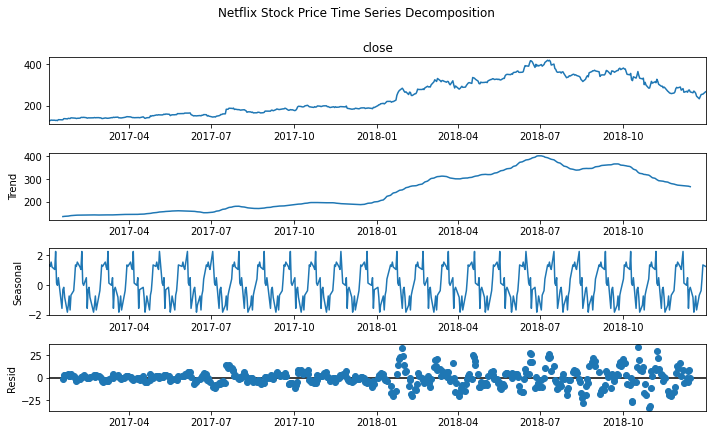

In [42]:
decomposition = StockModeler.decompose(nflx, 20) # 20 period frequency
fig = decomposition.plot()
fig.suptitle('Netflix Stock Price Time Series Decomposition', y=1)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout()

### ARIMA
We can use ARIMA to model the performance with autoregressive (AR), differences or lagged data (I), and moving average (MA) terms. The autocorrelation plot can help find a good starting point for this:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

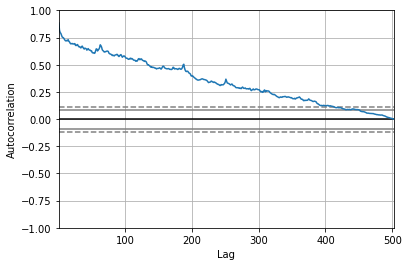

In [43]:
# we can use autocorrelation plots to find a good starting point for ARIMA
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(nflx)

ARIMA takes a long time to train, so we will start with an AR of 10:

In [44]:
# this takes a long time to run, so we will start with a smaller AR of 10
arima_model = StockModeler.arima(nflx, ar=10, i=1, ma=5)

The `summary()` method shows statistics on the model's performance:

In [45]:
# AR = 10, I = 1, MA = 5
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  519
Model:                ARIMA(10, 1, 5)   Log Likelihood               -1703.643
Method:                       css-mle   S.D. of innovations              6.440
Date:                Tue, 11 Aug 2020   AIC                           3441.286
Time:                        20:44:00   BIC                           3513.568
Sample:                    01-04-2017   HQIC                          3469.604
                         - 12-31-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2695      0.310      0.868      0.385      -0.339       0.878
ar.L1.D.close      0.1877      0.254      0.740      0.459      -0.309       0.685
ar.L2.D.close      1.1564      0.128

The residuals appear to be normally distributed (right subplot); however, their size appears to depend on time (left subplot), so this is not a good model:

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

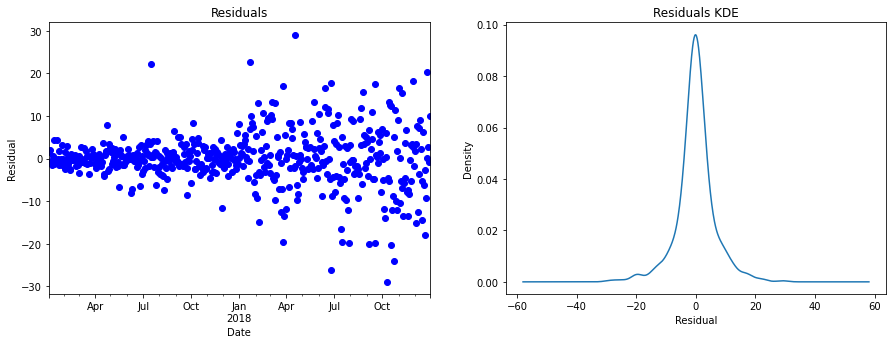

In [46]:
StockModeler.plot_residuals(arima_model)

### Linear Regression
We can build a linear regression using the last value to determine the next value:

In [47]:
X, Y, lm = StockModeler.regression(nflx)
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          7.156e+05
Date:                Tue, 11 Aug 2020   Prob (F-statistic):                        0.00
Time:                        20:45:25   Log-Likelihood:                         -1671.0
No. Observations:                 501   AIC:                                      3344.
Df Residuals:                     500   BIC:                                      3348.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Once again, the residuals appear to depend on time:

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

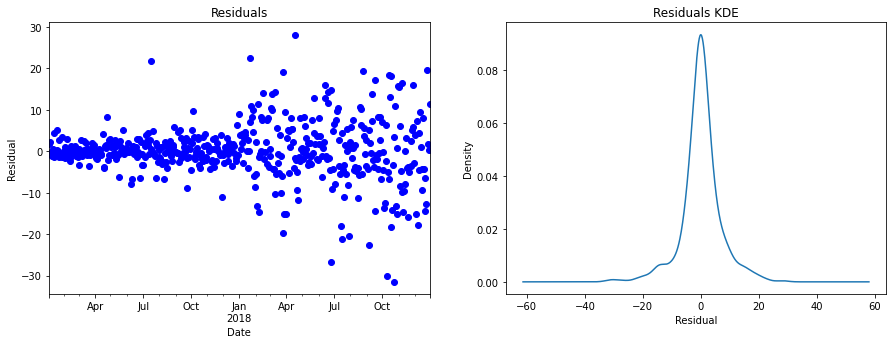

In [48]:
StockModeler.plot_residuals(lm)

### Compare Models Against Actuals
We can look at the predictions made. ARIMA looks like this:

Text(0, 0.5, 'price')

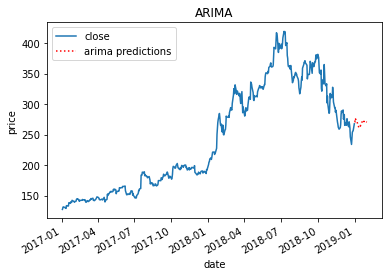

In [49]:
import datetime as dt

start = dt.date(2019, 1, 1)
end = dt.date(2019, 1, 31)

StockModeler.arima_predictions(
    nflx, arima_model, start=start, end=end, title='ARIMA'
)
plt.ylabel('price')

Let's see how these models compared to what actually happened:

Text(0, 0.5, 'price ($)')

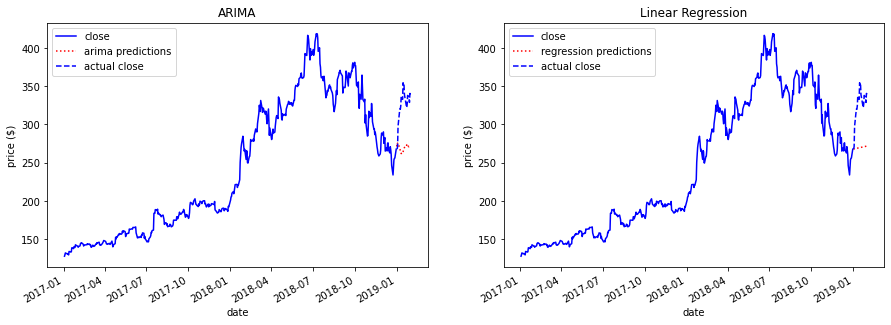

In [50]:
jan_2019 = stock_analysis.StockReader(
    start, end
).get_ticker_data('NFLX')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

arima_ax = StockModeler.arima_predictions(
    nflx, arima_model, start=start, end=end,
    ax=axes[0], title='ARIMA', color='b'
)
jan_2019.close.plot(ax=arima_ax, style='b--', label='actual close')
arima_ax.legend()
arima_ax.set_ylabel('price ($)')

linear_reg = StockModeler.regression_predictions(
    nflx, lm, start=start, end=end,
    ax=axes[1], title='Linear Regression', color='b'
)
jan_2019.close.plot(ax=linear_reg, style='b--', label='actual close')
linear_reg.legend()
linear_reg.set_ylabel('price ($)')

### Random Walks
Prediction is difficult due to randomness. Stock price can be modeled like a [random walk](https://en.wikipedia.org/wiki/Random_walk). Can you find the real stock data? 

*Note: To get different results, pass in a number to the `seed` argument.*

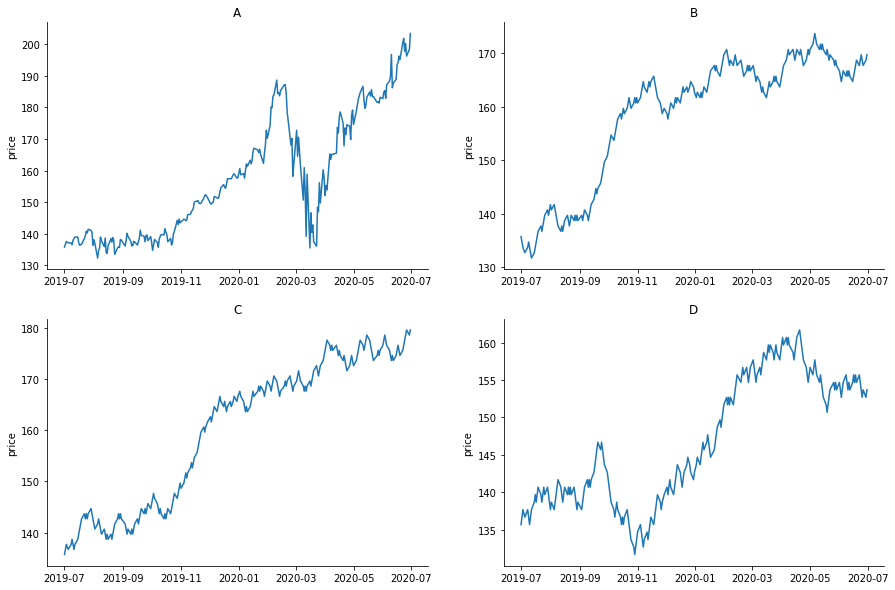

In [51]:
msft = stock_analysis.StockReader('2019-07-01', '2020-06-30').get_ticker_data('MSFT')
real_stock, axes = finance_viz.random_walk_stock_comparison(msft, probs=[0.45, 0.55])
plt.show()

Was your guess correct?

In [52]:
real_stock

'real stock is at location A'